# Exploratory Data Analysis (EDA) 

In [1]:
# TO DO PRIO 1: Make sure the extraction of salaries is working, even with decimals. 

# Vectorization 

# TO DO: fix requirements.txt file 

# Is this causing big problems later on? 
# df['column_name'] = df['column_name'].astype('category')

# Something is iffy with nltk and stopwords being loaded several times

In [2]:
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('system_profiler').setLevel(logging.ERROR)

In [3]:
# Standard library imports 
import os
import sys 

# Third-party imports 
#import langdetect as ld
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

# Local imports 
import utils.preprocessor as mf
import utils.plotting as pf
import utils.text_parser as tf
import utils.salary_extractor as sf
import utils.salary_extraction as sf2
import utils.dictionaries as dicts

# Activate autoreload for custom modules
%load_ext autoreload
%autoreload 2
%matplotlib inline

# File path definitions
DATA_PATH = os.getenv('DATA_PATH', 'data/')  # Use env variable or default
MISSING = os.path.join(DATA_PATH, 'df_FRA_missing_data.csv')
         
COUNTRIES = ['Sweden', 'France', 'Italy']

[nltk_data] Downloading package punkt to /Users/emmafrid/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/emmafrid/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# Check we're in the right environment
print(sys.executable)

/Users/emmafrid/Documents/GitHub/portfolio-projects/job-listings-scraper/salary_env/bin/python


## Load data
Import the data scraped using scraper-countries.py (Sept 20-21 2024), for the following countries: USA, Sweden, France, and Italy. These datasets contain the job listings for the 3 largest cities in respective country, for the job titles _Data Scientist_, _Data Analyst_, _Product Analyst_, and _BI Analyst_.

In [5]:
# Import csv files with scraped data for resp. country 
dfs = {
    country: pd.read_csv(os.path.join(DATA_PATH, f'indeed_jobs_{country}.csv'))
    for country in COUNTRIES
}

# Add USA data to the dictionary
dfs['USA'] = mf.merge_US_cities(['NY', 'LA', 'CHI'], os.path.join(DATA_PATH, 'indeed_jobs_'))

# Access individual country data as needed, e.g., dfs['Sweden']

Loaded data for NY
Column order for consistency: ['page', 'country', 'job_link', 'search_keyword', 'search_location', 'job_title', 'company_name', 'company_location', 'salary', 'job_description']


## Initial data inspection

In [6]:
dfs['Sweden'].head()

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,Sweden,https://se.indeed.com/rc/clk?jk=a54f123aa8f7ee...,Data+Analyst,Stockholm,Data Analyst (Data Visualization),Swedium Global Services,Distansjobb in Stockholm,Not available,Data Analyst (Data Visualization) \n \n Swediu...
1,1,Sweden,https://se.indeed.com/rc/clk?jk=5dbbee34feadd8...,Data+Analyst,Stockholm,Data Analyst,Deploja AB,169 73 Solna,Not available,Role: \n \n Website Performance: Web analyst f...
2,1,Sweden,https://se.indeed.com/rc/clk?jk=07cc3fa43334c5...,Data+Analyst,Stockholm,Data Analyst,Cubane Solutions AB,Stockholm,Heltid,Responsibilities \n \n Website Performance: W...
3,1,Sweden,https://se.indeed.com/rc/clk?jk=265b21402a8391...,Data+Analyst,Stockholm,Data Analyst,Sobi,Stockholm,Heltid,Company Description \n Statistics show that w...
4,1,Sweden,https://se.indeed.com/rc/clk?jk=65bfa8c313624f...,Data+Analyst,Stockholm,"Juniora Analysts till Operations, Engineering,...",Deloitte,113 57 Stockholm,Heltid,Företagsbeskrivning \n \n \n Deloitte är en g...


In [7]:
dfs['France'].head()

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,France,https://www.indeed.fr/rc/clk?jk=3163cc1d8a51ee...,Data+Analyst,Paris (75),CDI - Data analyst KYC - Senior F/H,La Banque Postale,Paris (75),CDI,INTRODUCTION \n Au sein de la direction Data ...
1,1,France,https://www.indeed.fr/rc/clk?jk=71fa252714d41c...,Data+Analyst,Paris (75),Data Analyst F/H,IZI Solutions Durables,Télétravail partiel à La Défense (92),CDI,"À propos \n \n En 2019, le Groupe EDF veut re..."
2,1,France,https://www.indeed.fr/rc/clk?jk=21f25c16a32522...,Data+Analyst,Paris (75),Data analyst,Le Groupe La Poste,Issy-les-Moulineaux (92),CDI,"La Poste Groupe change, nos métiers évoluent. ..."
3,1,France,https://www.indeed.fr/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,Paris (75),Data Analyst H/F,GROUPE ID SEARCH,Paris (75),"À partir de 35 000 € par an - CDI, Temps plein","Tertialis, société du groupe ID SEARCH, est sp..."
4,1,France,https://www.indeed.fr/rc/clk?jk=8c5cc311877c09...,Data+Analyst,Paris (75),Consultant Débutant Data Analyst en CDI - Pari...,EY,92037 La Défense,CDI,Participer à la digitalisation de nos clients ...


In [8]:
dfs['Italy'].head()

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",Business Intelligence (Power BI) - Python- Bus...,Area IT Group,"Roma, Lazio",25.000 € - 40.000 € all'anno,Ricerchiamo Sviluppatori in almeno uno dei seg...
1,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",Power Bi Analyst,Verisure Italy,00144 Roma,Not available,Ti piacerebbe far parte della multinazionale d...
2,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",IT Project Management Internship,Procter & Gamble,"Roma, Lazio",Not available,Job Location Rome Job Description INFORMATI...
3,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",Credit & Collection Data Analyst,Verisure Italy S R L,00144 Roma,Not available,Ti piacerebbe far parte della multinazionale d...
4,1,Italy,https://it.indeed.com/pagead/clk?mo=r&ad=-6NYl...,Data+Analyst,"Roma, Lazio",Aeronautical System Analyst,adecco,"Roma, Lazio",Not available,Per azienda leader a livello globale nella ges...


In [9]:
dfs['USA'].head()

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,USA,https://www.indeed.com/rc/clk?jk=5bf7eb172149d...,Data+Analyst,"New+York, NY",Business Analyst (Data products),Aon,"Remote in New York, NY","$80,000 - $95,000 a year - Full-time","Senior Associate Consultant, Data Solutions ..."
1,1,USA,https://www.indeed.com/rc/clk?jk=6b99bd10f1316...,Data+Analyst,"New+York, NY",Data Analyst,NYU Langone,"New York, NY",$32.38 - $39.01 an hour - Temporary,NYU Grossman School of Medicine is one of the...
2,1,USA,https://www.indeed.com/rc/clk?jk=d70c515431fa2...,Data+Analyst,"New+York, NY",Data Analyst,NYU Langone Health,"New York, NY 10016","$67,771.14 - $75,000.00 a year - Full-time",NYU Grossman School of Medicine is one of the...
3,1,USA,https://www.indeed.com/rc/clk?jk=3aa26222eadd6...,Data+Analyst,"New+York, NY","Resy Marketing Data Analyst, Data and Analytics",Amex,"Hybrid work in New York, NY","$60,000 - $110,000 a year",You Lead the Way. We’ve Got Your Back. \n With...
4,1,USA,https://www.indeed.com/rc/clk?jk=3aa564ce173c8...,Data+Analyst,"New+York, NY",2025 University Graduate - Digital Strategy An...,Adobe,"New York, NY 10012","$53,900 - $101,450 a year - Full-time",Our Company Changing the world through digit...


### Check dimensions and data types

In [10]:
# Check dimensions of dfs 
for country, df in dfs.items(): 
    print(f'{country} \t   columns: {dfs[country].shape[1]} \t  rows: {dfs[country].shape[0]}')

Sweden 	   columns: 10 	  rows: 320
France 	   columns: 10 	  rows: 2200
Italy 	   columns: 10 	  rows: 769
USA 	   columns: 10 	  rows: 1317


In [11]:
# Check data types
dfs['Sweden'].info() 
# Convert columns with strings only to string data type to optimize performance
# Mixed columns with both numbers and strings that should be kept as object: company_location, salary, job_link (url)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   page              320 non-null    int64 
 1   country           320 non-null    object
 2   job_link          320 non-null    object
 3   search_keyword    320 non-null    object
 4   search_location   320 non-null    object
 5   job_title         320 non-null    object
 6   company_name      320 non-null    object
 7   company_location  320 non-null    object
 8   salary            320 non-null    object
 9   job_description   320 non-null    object
dtypes: int64(1), object(9)
memory usage: 25.1+ KB


In [12]:
dicts.dtype_dict

{'page': 'int64',
 'country': 'string',
 'job_link': 'object',
 'search_keyword': 'category',
 'search_location': 'string',
 'job_title': 'string',
 'company_name': 'string',
 'company_location': 'object',
 'salary': 'object',
 'job_description': 'string'}

In [13]:
# Convert columns to the correct data types 
for country, df in dfs.items():
    dfs[country] = dfs[country].astype(dicts.dtype_dict)

print(dfs['Sweden'].dtypes)

page                         int64
country             string[python]
job_link                    object
search_keyword            category
search_location     string[python]
job_title           string[python]
company_name        string[python]
company_location            object
salary                      object
job_description     string[python]
dtype: object


In [14]:
dfs['Sweden'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   page              320 non-null    int64   
 1   country           320 non-null    string  
 2   job_link          320 non-null    object  
 3   search_keyword    320 non-null    category
 4   search_location   320 non-null    string  
 5   job_title         320 non-null    string  
 6   company_name      320 non-null    string  
 7   company_location  320 non-null    object  
 8   salary            320 non-null    object  
 9   job_description   320 non-null    string  
dtypes: category(1), int64(1), object(3), string(5)
memory usage: 23.1+ KB


### Conclusions
- The following columns needs to be cleaned: search_keyword, job_title, job_description, company_location.   
- The salary column should be split into two columns (separate numeric vs string content).    

## Data Quality Assessment
Data reduction and data cleaning

### Missing values

In [15]:
# The scraper labels cells as 'Not available' when there is no value. Change these to NaN. 
for country, df in dfs.items():
    df.replace('Not available', np.nan, inplace=True)
    nan_counts = df.isnull().sum()
    #nan_percentage = df.isnull().mean()*100
    print(f'Missing values for {country}:')
    print(f'{nan_counts}\n')

Missing values for Sweden:
page                  0
country               0
job_link              0
search_keyword        0
search_location       0
job_title             0
company_name          0
company_location      0
salary              183
job_description       0
dtype: int64

Missing values for France:
page                  0
country               0
job_link              0
search_keyword        0
search_location       0
job_title             0
company_name          0
company_location      0
salary              378
job_description      51
dtype: int64

Missing values for Italy:
page                  0
country               0
job_link              0
search_keyword        0
search_location       0
job_title             0
company_name          0
company_location      0
salary              746
job_description       0
dtype: int64

Missing values for USA:
page                 0
country              0
job_link             0
search_keyword       0
search_location      0
job_title          

Salary entries will be examined more in detail later when columns are split.  For now we do not drop these rows (we are not primarily interested in salaries). 

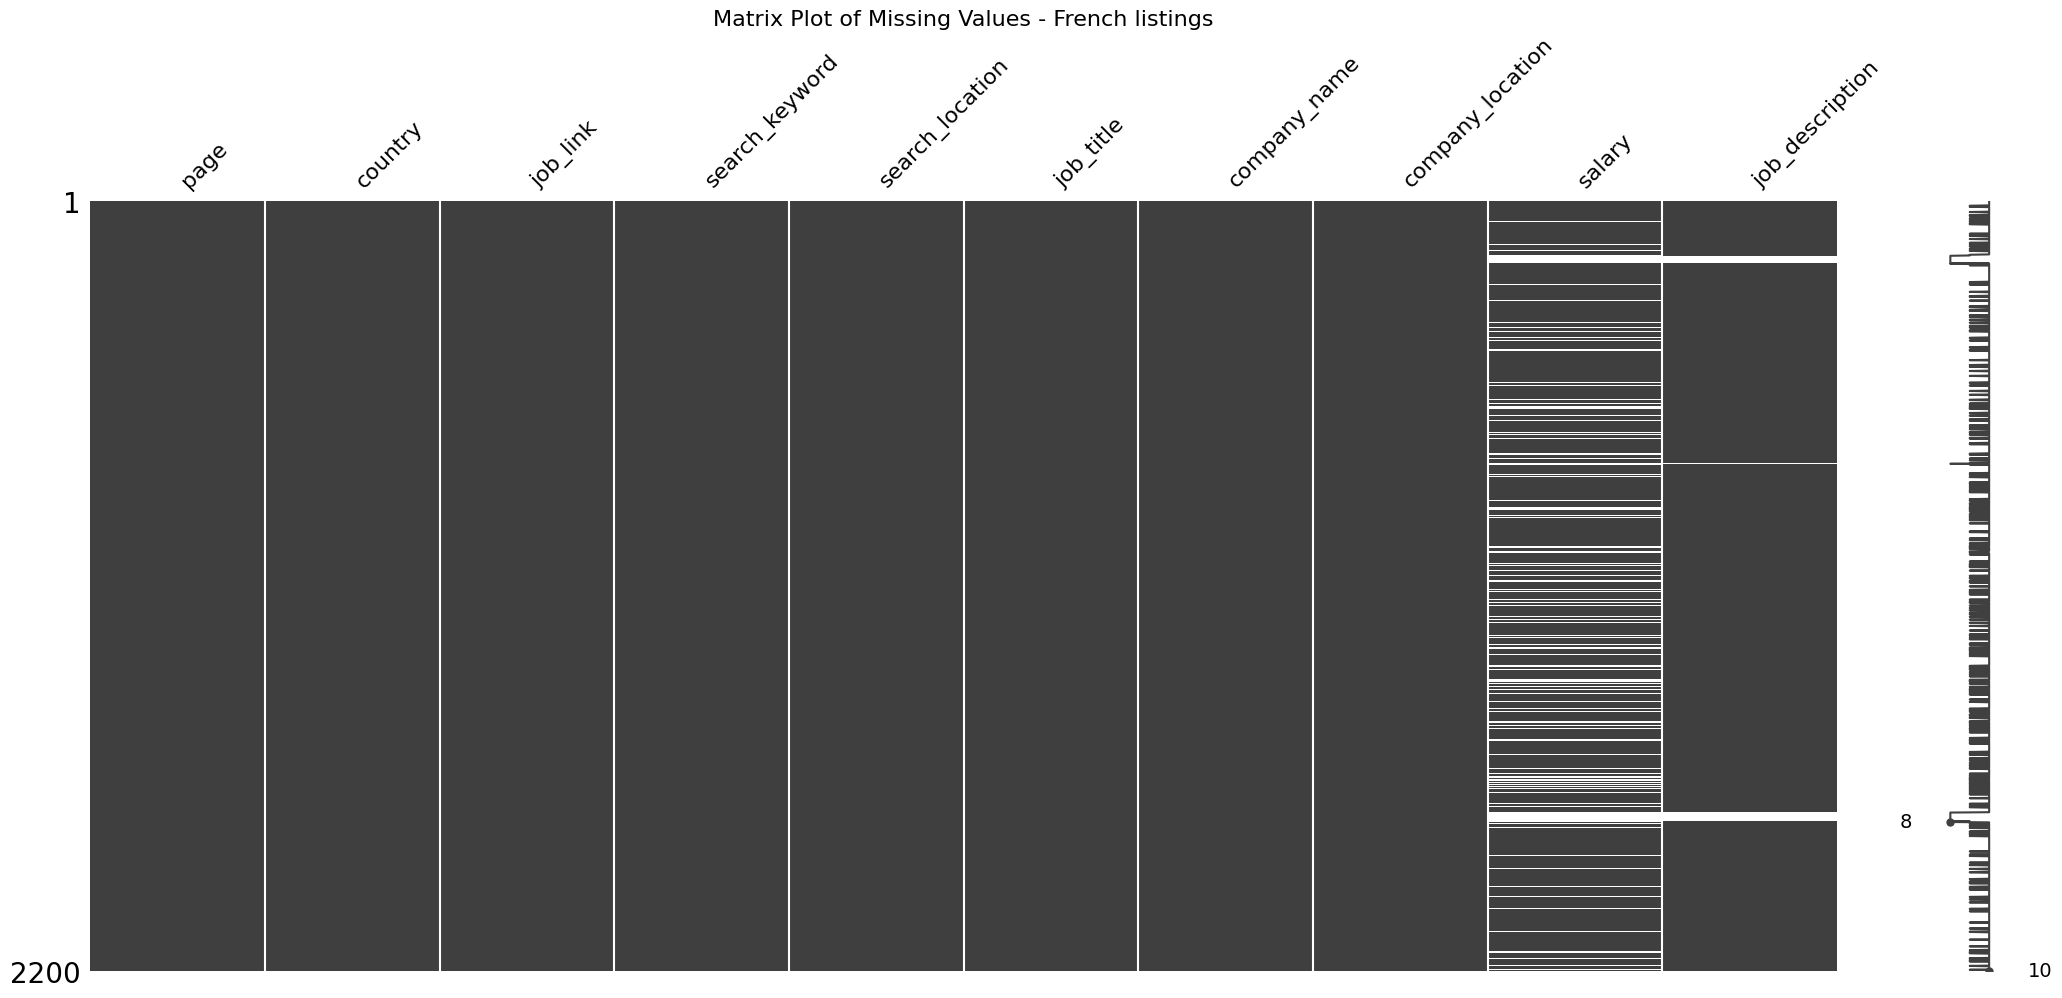

In [16]:
# Visualize missing data patterns using missingno
msno.matrix(dfs['France']) #.sample(250)
plt.title('Matrix Plot of Missing Values - French listings', fontsize=16) 
plt.show()

In [17]:
# Look into the missing descriptions for French job listings (seems that scraper requests were blocked here?)
print(dfs['France'].isnull().sum())
dfs['France'][dfs['France']['job_description'].isnull()].head()

# Manual imports of missing job descriptions from URLs 
df_FRA_missing = pd.read_csv(MISSING)

page                  0
country               0
job_link              0
search_keyword        0
search_location       0
job_title             0
company_name          0
company_location      0
salary              378
job_description      51
dtype: int64


In [18]:
# Merge the DataFrames based on the 'job_link' column
merged_df = pd.merge(dfs['France'], df_FRA_missing[['job_link', 'job_description_new']], on='job_link', how='left')

# Use combine_first to fill 'job_description' column more efficiently
merged_df['job_description'] = merged_df['job_description'].combine_first(merged_df['job_description_new'])

# Drop 'job_description_new' column efficiently
merged_df.drop(columns='job_description_new', inplace=True)

# Verify that there are no missing values in 'job_description'
merged_df.isnull().sum()
dfs['France'] = merged_df
print(dfs['France'].isnull().sum())

page                  0
country               0
job_link              0
search_keyword        0
search_location       0
job_title             0
company_name          0
company_location      0
salary              378
job_description       0
dtype: int64


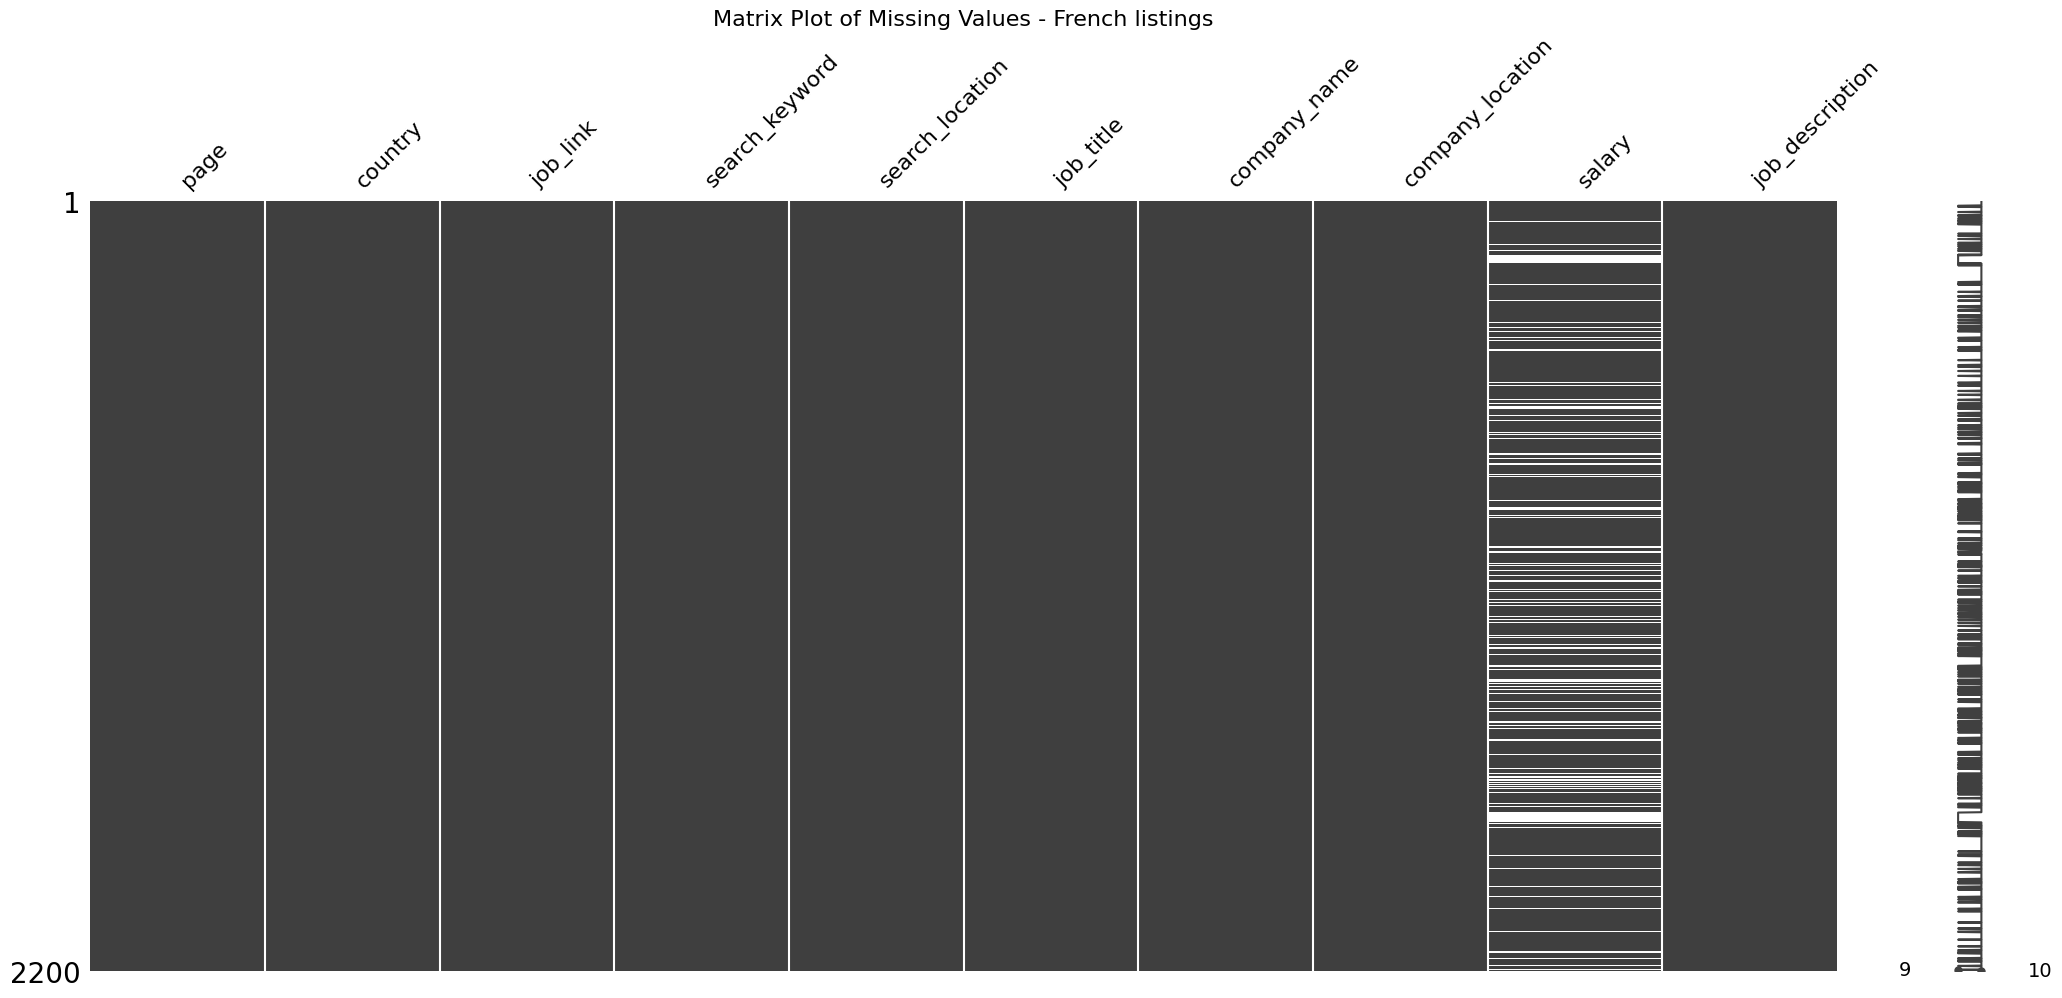

In [19]:
# Now the job_description should not have missing values anymore
msno.matrix(dfs['France']) #.sample(250)
plt.title('Matrix Plot of Missing Values - French listings', fontsize=16)  
plt.show()

In [20]:
# Make sure all data types are the same after adding info from CSV
dfs['France'] = dfs['France'].astype(dicts.dtype_dict)
print(dfs['France'].dtypes)

page                         int64
country             string[python]
job_link                    object
search_keyword            category
search_location     string[python]
job_title           string[python]
company_name        string[python]
company_location            object
salary                      object
job_description     string[python]
dtype: object


In [21]:
# There are still many missing values for salary
# This information was not always provided in the job listings
dfs['France']['salary'].isnull().sum()

np.int64(378)

### Check for duplicates

In [22]:
# Check for potential duplicates 
for country, df in dfs.items():
    print(f'Duplicates for {country} :')
    mf.check_duplicates(df)
    print('\n')

Duplicates for Sweden :
The DataFrame has 320 rows.
Empty DataFrame
Columns: [page, country, job_link, search_keyword, search_location, job_title, company_name, company_location, salary, job_description]
Index: []


Duplicates for France :
The DataFrame has 2200 rows.
Empty DataFrame
Columns: [page, country, job_link, search_keyword, search_location, job_title, company_name, company_location, salary, job_description]
Index: []


Duplicates for Italy :
The DataFrame has 769 rows.
Empty DataFrame
Columns: [page, country, job_link, search_keyword, search_location, job_title, company_name, company_location, salary, job_description]
Index: []


Duplicates for USA :
The DataFrame has 1317 rows.
Empty DataFrame
Columns: [page, country, job_link, search_keyword, search_location, job_title, company_name, company_location, salary, job_description]
Index: []




No rows are completely identical, but perhaps there are <i>job descriptions</i> that are identical? 

In [23]:
# Identify duplicates (same job title, location, and job description, and keep only the latest job listing(
for country, df in dfs.items():
    df = mf.remove_duplicates_jobdesc(df) 

There are duplicate values based on 'job_description', 'search_location', and 'job_title' columns.
Size before: 3200. Size after removing duplicates: 2630 

There are duplicate values based on 'job_description', 'search_location', and 'job_title' columns.
Size before: 22000. Size after removing duplicates: 13650 

There are duplicate values based on 'job_description', 'search_location', and 'job_title' columns.
Size before: 7690. Size after removing duplicates: 5690 

There are duplicate values based on 'job_description', 'search_location', and 'job_title' columns.
Size before: 13170. Size after removing duplicates: 8350 



There are numerous examples of completely identical job descriptions. These are likely reposts (the same job appearing multiple times, just with different unique links!). 
<b>Remove these entries if the job titles are the same and the locations are the same.</b> 

### Clean columns

In [24]:
# Clean search_keyword and search_location columns: replace '+' with ' ' 
for country, df in dfs.items():
    # Convert to string 
    df['search_keyword'] = df['search_keyword'].astype(str)    
    df['search_location'] = df['search_location'].astype(str)    
    # Replace '+' with ' '
    df['search_keyword'] = df['search_keyword'].str.replace('+', ' ')
    df['search_location'] = df['search_location'].astype(str)    
    # Convert back to a categorical 
    df['search_keyword'] = pd.Categorical(df['search_keyword'])
    df['search_location'] = pd.Categorical(df['search_location'])

# Verify that it worked 
dfs['Sweden'].head(3)

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,Sweden,https://se.indeed.com/rc/clk?jk=a54f123aa8f7ee...,Data Analyst,Stockholm,Data Analyst (Data Visualization),Swedium Global Services,Distansjobb in Stockholm,NaN,Data Analyst (Data Visualization) Swedium ...
1,1,Sweden,https://se.indeed.com/rc/clk?jk=5dbbee34feadd8...,Data Analyst,Stockholm,Data Analyst,Deploja AB,169 73 Solna,NaN,Role: Website Performance: Web analyst foc...
2,1,Sweden,https://se.indeed.com/rc/clk?jk=07cc3fa43334c5...,Data Analyst,Stockholm,Data Analyst,Cubane Solutions AB,Stockholm,Heltid,Responsibilities Website Performance: Web...


In [25]:
# Clean job_title column 
for country, df in dfs.items():
    df['job_title'] = df['job_title'].str.lower()

    # Handle French-specific cleaning
    if country == 'France':
        df['job_title'] = df['job_title'].str.replace(r'\(?(h/f|f/h)\)?', '', regex=True).str.strip()

dfs['France']['job_title']

0                         cdi - data analyst kyc - senior
1                                            data analyst
2                                            data analyst
3                                            data analyst
4       consultant débutant data analyst en cdi - pari...
                              ...                        
2195                    commercial performance data owner
2196    consultant en gestion et gouvernance de l'info...
2197                                               devops
2198                                            tech lead
2199    senior financial data analyst | deals (m&a) | ...
Name: job_title, Length: 2200, dtype: string

In [26]:
# Clean job_description column 
# TO DO 

## Descriptive statistics

In [27]:
# Describe (numerical) columns  
dfs['France'].describe(include='all').head()

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
count,2200.000000,2200,2200,2200,2200,2200,2200,2200,1822,2200
unique,NaN,1,2200,4,3,1153,718,256,164,1355
top,NaN,France,https://www.indeed.fr/rc/clk?jk=87348216f5b0a7...,Data Analyst,Paris (75),data analyst,AXA,Paris (75),Temps plein,Line of Service Advisory \n \n Industry/Sect...
freq,NaN,2200,1,757,1949,96,64,582,512,16
mean,17.454091,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# Describe categorical columns  
mf.desc_categorical(dfs['France'])

Value counts for column: country
country
France    2200
Name: count, dtype: Int64

Value counts for column: job_title
job_title
data analyst                                             96
data scientist                                           40
business analyst                                         18
data analyst intern                                      17
senior product data analyst                              13
                                                         ..
alternant(e) sales & operations planning (s&op)           1
mlops engineer                                            1
data ingénieur                                            1
analyste fp&a senior /nb                                  1
consultant en gestion et gouvernance de l'information     1
Name: count, Length: 1153, dtype: Int64

Value counts for column: company_name
company_name
AXA                   64
PwC                   27
HERMES SELLIER        25
Capgemini             24
VINCI Construction  

### Preliminary observations, Swedish job listings:
- __Most frequent job titles__: Systemutvecklare, Data Analyst, Data Scientist.
- __Most frequent company__: Cubane Solutions AB. 
- __Company location__: Stockholm primarily. 
- __Salary ranges__: Few numerical values are provided.

In [29]:
dfs['France'].describe(include='all').head(4)

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
count,2200.0,2200,2200,2200,2200,2200,2200,2200,1822,2200
unique,NaN,1,2200,4,3,1153,718,256,164,1355
top,NaN,France,https://www.indeed.fr/rc/clk?jk=87348216f5b0a7...,Data Analyst,Paris (75),data analyst,AXA,Paris (75),Temps plein,Line of Service Advisory \n \n Industry/Sect...
freq,NaN,2200,1,757,1949,96,64,582,512,16


In [30]:
mf.desc_categorical(dfs['France']) 

Value counts for column: country
country
France    2200
Name: count, dtype: Int64

Value counts for column: job_title
job_title
data analyst                                             96
data scientist                                           40
business analyst                                         18
data analyst intern                                      17
senior product data analyst                              13
                                                         ..
alternant(e) sales & operations planning (s&op)           1
mlops engineer                                            1
data ingénieur                                            1
analyste fp&a senior /nb                                  1
consultant en gestion et gouvernance de l'information     1
Name: count, Length: 1153, dtype: Int64

Value counts for column: company_name
company_name
AXA                   64
PwC                   27
HERMES SELLIER        25
Capgemini             24
VINCI Construction  

### Preliminary observations, French job listings:
- Many listings compared to Sweden. 
- __Most frequent job titles__: Data Analyst (many similar names for this title, e.g. Data Analyst H/F and Data Analyst Intern). 
- __Most frequently mentioned company__: AXA.
- __Company location__: Most in Paris. Includes some information about télétravail (especially common in Paris).  
- __Salary ranges__: Need to split column to be able to draw any conclusions.

In [31]:
dfs['Italy'].describe(include='all').head(4)

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
count,769.0,769,769,769,769,769,769,769,23,769
unique,NaN,1,769,4,3,454,309,96,14,554
top,NaN,Italy,https://it.indeed.com/rc/clk?jk=46de7544ab716b...,Data Analyst,"Milano, Lombardia",data scientist,BIP - Business Integration Partners,"Milano, Lombardia",52.246 € all'anno,Company: TELEPASS ASSICURA\n \n \n \n \n ...
freq,NaN,769,1,419,540,34,39,207,7,5


In [32]:
mf.desc_categorical(dfs['Italy']) 

Value counts for column: country
country
Italy    769
Name: count, dtype: Int64

Value counts for column: job_title
job_title
data scientist                                                       34
data analyst                                                         29
business analyst                                                     19
senior data analyst                                                  11
cyber security analyst                                                6
                                                                     ..
process analyst                                                       1
business analyst trainee                                              1
supply chain analyst - con inglese                                    1
market analyst                                                        1
front end data analyst - area artificial intelligence & analytics     1
Name: count, Length: 454, dtype: Int64

Value counts for column: company_name
comp

### Preliminary observations, Italian job listings:
- Many listings compared to Sweden, but less than France.
- __Most frequent job titles__: Data Analyst, Data Scientist, Business Analyst. 
- __Most frequently mentioned company__: BIP - Business Integration Partners. 
- __Company location__: Milano. Also remote in Milano is relatively common (as is Rome).
- __Salary ranges__: Very few numerical entries provided. 

In [33]:
dfs['USA'].describe(include='all').head(4)

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
count,1317.0,1317,1317,1317,1317,1317,1317,1317,1230,1317
unique,NaN,1,1317,4,3,737,470,185,524,823
top,NaN,USA,https://www.indeed.com/rc/clk?jk=274ddb9b95715...,Data Analyst,"New+York, NY",data analyst,Citi,"New York, NY",Full-time,~Hybrid Work Schedule consists of reporting to...
freq,NaN,1317,1,522,771,29,44,269,236,6


In [34]:
mf.desc_categorical(dfs['USA']) 

Value counts for column: country
country
USA    1317
Name: count, dtype: Int64

Value counts for column: job_title
job_title
data analyst                                           29
business analyst                                       25
senior business analyst                                19
senior machine learning engineer                       14
senior data analyst                                    11
                                                       ..
senior business process analyst, premium accounting     1
sr agriculture business line manager analyst            1
business systems analyst - salesforce                   1
business analyst iv                                     1
third party risk reporting analyst                      1
Name: count, Length: 737, dtype: Int64

Value counts for column: company_name
company_name
Citi                        44
JPMorganChase               25
Publicis Sapient            18
Google                      15
Amazon.com Services LL

### Preliminary observations, American job listings:
- Number of listings are less than for France. 
- __Most frequent job titles__: Data Analyst, BI analyst, (Senior) Data Scientist. Interesting that Machine Learning Engineer shows up. Might need to cluster similar terms to get full picture (e.g. remove Senior etc.). 
- __Most frequently mentioned company__: Citi. 
- __Company location__: New York.  
- __Salary ranges__: Need to split column to draw conclusions. 

## Feature engineering 

In [35]:
# Merge all dfs in the dictionary into a single df
df_combined = pd.concat(dfs.values(), ignore_index=True)
df_combined.reset_index(drop=True, inplace=True)
# Add dates when data was scraped 
df_combined['date'] = np.where(df_combined['country'].isin(['Sweden', 'USA']), pd.to_datetime('2024-09-19'), pd.to_datetime('2024-09-20'))

df_combined.head()

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description,date
0,1,Sweden,https://se.indeed.com/rc/clk?jk=a54f123aa8f7ee...,Data Analyst,Stockholm,data analyst (data visualization),Swedium Global Services,Distansjobb in Stockholm,NaN,Data Analyst (Data Visualization) Swedium ...,2024-09-19
1,1,Sweden,https://se.indeed.com/rc/clk?jk=5dbbee34feadd8...,Data Analyst,Stockholm,data analyst,Deploja AB,169 73 Solna,NaN,Role: Website Performance: Web analyst foc...,2024-09-19
2,1,Sweden,https://se.indeed.com/rc/clk?jk=07cc3fa43334c5...,Data Analyst,Stockholm,data analyst,Cubane Solutions AB,Stockholm,Heltid,Responsibilities Website Performance: Web...,2024-09-19
3,1,Sweden,https://se.indeed.com/rc/clk?jk=265b21402a8391...,Data Analyst,Stockholm,data analyst,Sobi,Stockholm,Heltid,Company Description Statistics show that wo...,2024-09-19
4,1,Sweden,https://se.indeed.com/rc/clk?jk=65bfa8c313624f...,Data Analyst,Stockholm,"juniora analysts till operations, engineering,...",Deloitte,113 57 Stockholm,Heltid,Företagsbeskrivning Deloitte är en glob...,2024-09-19


### Retrieve numeric values for salary

In [36]:
dfs['Sweden']

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description
0,1,Sweden,https://se.indeed.com/rc/clk?jk=a54f123aa8f7ee...,Data Analyst,Stockholm,data analyst (data visualization),Swedium Global Services,Distansjobb in Stockholm,NaN,Data Analyst (Data Visualization) Swedium ...
1,1,Sweden,https://se.indeed.com/rc/clk?jk=5dbbee34feadd8...,Data Analyst,Stockholm,data analyst,Deploja AB,169 73 Solna,NaN,Role: Website Performance: Web analyst foc...
2,1,Sweden,https://se.indeed.com/rc/clk?jk=07cc3fa43334c5...,Data Analyst,Stockholm,data analyst,Cubane Solutions AB,Stockholm,Heltid,Responsibilities Website Performance: Web...
3,1,Sweden,https://se.indeed.com/rc/clk?jk=265b21402a8391...,Data Analyst,Stockholm,data analyst,Sobi,Stockholm,Heltid,Company Description Statistics show that wo...
4,1,Sweden,https://se.indeed.com/rc/clk?jk=65bfa8c313624f...,Data Analyst,Stockholm,"juniora analysts till operations, engineering,...",Deloitte,113 57 Stockholm,Heltid,Företagsbeskrivning Deloitte är en glob...
...,...,...,...,...,...,...,...,...,...,...
315,1,Sweden,https://se.indeed.com/rc/clk?jk=8833f20aec008e...,BI Analyst,Göteborg,senior business intelligence analyst,Wolters Kluwer,Göteborg,Heltid,We are seeking a European Senior Business Inte...
316,1,Sweden,https://se.indeed.com/rc/clk?jk=32590120771529...,BI Analyst,Göteborg,senior logistics analyst,Volvo Cars AB,405 31 Göteborg,NaN,Within Data and Supply Chain Innovation st...
317,1,Sweden,https://se.indeed.com/rc/clk?jk=4b496adb2b60e2...,BI Analyst,Göteborg,it business analyst customs,Techster Solutions AB,Göteborg,"Tillsvidare, Heltid",Techster Solutions befinner i dagsläget sig i ...
318,1,Sweden,https://se.indeed.com/rc/clk?jk=6d7504e7756153...,BI Analyst,Malmö,powerbi utvecklare,Sogeti,Malmö,NaN,Ansök nu Är du Data Analyst/BI Ut...


In [37]:
# Data Cleaning and Preprocessing:
# Language Identification: identify the language of each job description.
# Please note that this might take 1 min for the entire dataset
df_combined['language']=df_combined['job_description'].apply(tf.detect_language)

In [38]:
df_combined.tail(3)

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description,date,language
4603,7,USA,https://www.indeed.com/rc/clk?jk=558d0dbb26f8f...,BI Analyst,"Chicago, IL",business analyst,Allwyn North America,"Hybrid work in Chicago, IL 60606",Full-time,Who we are: Allwyn is a multi-national lotte...,2024-09-19,en
4604,7,USA,https://www.indeed.com/rc/clk?jk=eb60bd8e996a0...,BI Analyst,"Chicago, IL","senior financial analyst, north america commer...",Flexport,"Hybrid work in Chicago, IL","$88,000 - $120,000 a year","About Flexport: At Flexport, we believe glob...",2024-09-19,en
4605,7,USA,https://www.indeed.com/rc/clk?jk=274ddb9b95715...,BI Analyst,"Chicago, IL","sr. director of data, analytics and ai",NinjaTrader,"Hybrid work in Chicago, IL",NaN,JOIN US ON OUR MISSION TO BECOME THE #1 RETAIL...,2024-09-19,en


In [39]:
# Text Normalization: Remove stop words, punctuation, and other irrelevant elements.
# Group the DataFrame by language
def normalize_group(group):
    print(f'Normalizing text for language group: {group.name}')
    group['normalized_text'] = group['job_description'].apply(lambda x: tf.normalize_text(x, group.name, dicts.language_map))
    return group

normalized_df = df_combined.groupby('language').apply(normalize_group)

Normalizing text for language group: en
Normalizing text for language group: fr
Normalizing text for language group: it
Normalizing text for language group: sv


In [40]:
# Revert to format before groupby
# Reset the index to remove 'language' from being an index
normalized_df = normalized_df.reset_index(drop=True)
normalized_df.head(3)

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description,date,language,normalized_text
0,1,Sweden,https://se.indeed.com/rc/clk?jk=a54f123aa8f7ee...,Data Analyst,Stockholm,data analyst (data visualization),Swedium Global Services,Distansjobb in Stockholm,NaN,Data Analyst (Data Visualization) Swedium ...,2024-09-19,en,data analyst data visualization swedium global...
1,1,Sweden,https://se.indeed.com/rc/clk?jk=5dbbee34feadd8...,Data Analyst,Stockholm,data analyst,Deploja AB,169 73 Solna,NaN,Role: Website Performance: Web analyst foc...,2024-09-19,en,role website performance web analyst focus spe...
2,1,Sweden,https://se.indeed.com/rc/clk?jk=07cc3fa43334c5...,Data Analyst,Stockholm,data analyst,Cubane Solutions AB,Stockholm,Heltid,Responsibilities Website Performance: Web...,2024-09-19,en,responsibility website performance web analyst...


In [41]:
normalized_df[['job_description', 'normalized_text', 'language']]

,job_description,normalized_text,language
0,Data Analyst (Data Visualization) Swedium ...,data analyst data visualization swedium global...,en
1,Role: Website Performance: Web analyst foc...,role website performance web analyst focus spe...,en
2,Responsibilities Website Performance: Web...,responsibility website performance web analyst...,en
3,Company Description Statistics show that wo...,company description statistic show woman under...,en
4,Northmill Bank is a pioneering financial insti...,northmill bank pioneering financial institutio...,en
...,...,...,...
4601,Är du en nyfiken person med god social förmåga...,nyfiken person god social förmåga driv lära ny...,sv
4602,Techster Solutions befinner i dagsläget sig i...,techster solution befinner dagsläget spännande...,sv
4603,På TechSeed är vi övertygade om att det är tek...,techseed övertygade tekniken kommer göra värld...,sv
4604,Techster Solutions befinner i dagsläget sig i ...,techster solution befinner dagsläget spännande...,sv


In [42]:
normalized_df['language'] = normalized_df['language'].map(dicts.language_map)

# Check the result
print(normalized_df['language'].unique())
normalized_df.head()

['english' 'french' 'italian' 'swedish']


,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description,date,language,normalized_text
0,1,Sweden,https://se.indeed.com/rc/clk?jk=a54f123aa8f7ee...,Data Analyst,Stockholm,data analyst (data visualization),Swedium Global Services,Distansjobb in Stockholm,NaN,Data Analyst (Data Visualization) Swedium ...,2024-09-19,english,data analyst data visualization swedium global...
1,1,Sweden,https://se.indeed.com/rc/clk?jk=5dbbee34feadd8...,Data Analyst,Stockholm,data analyst,Deploja AB,169 73 Solna,NaN,Role: Website Performance: Web analyst foc...,2024-09-19,english,role website performance web analyst focus spe...
2,1,Sweden,https://se.indeed.com/rc/clk?jk=07cc3fa43334c5...,Data Analyst,Stockholm,data analyst,Cubane Solutions AB,Stockholm,Heltid,Responsibilities Website Performance: Web...,2024-09-19,english,responsibility website performance web analyst...
3,1,Sweden,https://se.indeed.com/rc/clk?jk=265b21402a8391...,Data Analyst,Stockholm,data analyst,Sobi,Stockholm,Heltid,Company Description Statistics show that wo...,2024-09-19,english,company description statistic show woman under...
4,1,Sweden,https://se.indeed.com/rc/clk?jk=fb1e2e93534efa...,Data Analyst,Stockholm,data analyst,Northmill,111 53 Stockholm,NaN,Northmill Bank is a pioneering financial insti...,2024-09-19,english,northmill bank pioneering financial institutio...


In [133]:
normalized_df.shape

(4606, 17)

In [ ]:
# Process Swedish jobs
swedish_results = sf2.process_job_descriptions(normalized_df, 
                                         country='sweden',
                                         text_column='normalized_text',
                                         country_column='country')


# Process French jobs
french_results = sf2.process_job_descriptions(normalized_df, 
                                        country='france',
                                        text_column='normalized_text',
                                        country_column='country')

In [175]:

# Process US jobs
us_results = sf2.process_job_descriptions(normalized_df[1295:], 
                                    country='usa',
                                    text_column='normalized_text',
                                    country_column='country')



# See successful extractions with time periods
successful_extractions = us_results[us_results['salary_extraction_success'] == True]
successful_extractions[['normalized_text', 'min_salary', 'max_salary', 'currency', 'time_period']]

# Check success rate
success_rate = us_results['salary_extraction_success'].mean()
print(f"Salary extraction success rate: {success_rate:.2%}")


Processing rows for usa:
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

Row 1297: Found $
Context: 'salary range full-time position 177,000-$266,000  bonus  equity  benefi'
Numbers found in this context: ['177,000', '266,000']
All numbers found: ['177,000', '266,000']
Global min value: 177,000
Global max value: 266,000
Time unit found: per year
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------

In [179]:
us_results.loc[us_results['salary_extraction_success'], ['language', 'min_salary', 'max_salary', 'currency', 'time_period']]

# look into 1897, 1891, 2004, 1886, 1813, 1726, 1698

,language,min_salary,max_salary,currency,time_period
1297,english,"177,000","266,000",$,per year
1304,english,"81,000","81,000",usd,per year
1310,english,"81,000","81,000",usd,per year
1312,english,"149,000","165,500",usd,per year
1324,english,"120,000","140,000",$,per year
1325,english,"146,000","216,000",$,per year
1326,english,"117,200","250,200",usd,per year
1332,english,"161,000","239,000",$,per year
1337,english,"144,400.00","216,600.00",$,per year
1343,english,"185,000","205,500",usd,per year


In [155]:
successful_extractions = us_results[us_results['salary_extraction_success'] == True]
pd.set_option('display.max_rows', None)
print(successful_extractions[['min_salary', 'max_salary', 'currency', 'time_period']])

      min_salary  max_salary currency time_period
1087      80,000      80,000        $    per year
1088     103,800     162,000      usd    per year
1089     145,000     145,000        $    per year
1095      80,000      80,000        $    per year
1100     118,000     118,000        $    per year
1102     120,000     120,000        $    per year
1106     103,800     162,000      usd    per year
1109     105,500     105,500        $    per year
1110     150,000     150,000        $    per year
1111     125,000     125,000        $    per year
1116     118,000     118,000        $    per year
1117          45          45        $    per hour
1119  192,300.00  192,300.00        $    per year
1123     200,000     200,000        $    per year
1126          45          45        $    per hour
1143     192,300  192,300.00        $    per year
1145     120,000     120,000        $    per year
1152   70,000.00   90,000.00      usd    per year
1154     130,000     130,000        $    per year


In [108]:
pd.set_option('display.max_colwidth', None)

subset=result_df#[result_df['country'] == 'Sweden']
print(subset.currency.value_counts())
print(subset.salary_extraction_success.value_counts())
#subset[['normalized_text', 'min_salary', 'max_salary', 'currency', 'time_period']]

# seems like currency sign is ok in terms of extraction
# maybe just try to find salary info around it? 

currency
      42
kr     8
Name: count, dtype: int64
salary_extraction_success
False    50
Name: count, dtype: int64


In [98]:
#subset.min_salary.notnull()
subset[subset[['min_salary']].notnull().all(1)]['min_salary']

120         22.5
125          2.0
136         22.5
137          2.0
168        850.0
          ...   
2273    830500.0
2336        16.5
2347        16.5
2354        22.5
2378        22.5
Name: min_salary, Length: 153, dtype: object

In [90]:
result_df.info()
# Rule-Based Extraction:
# Keyword Matching: Use keywords like "salary," "pay," "wage," "annual," "monthly," "hourly" to identify relevant parts of the text.
# Regular Expressions: Use regular expressions to extract numerical values and currency symbols.

# Hybrid Approach:
# Combine NER and rule-based techniques for robust extraction.
# Use NER to identify potential salary-related entities, and then apply rule-based techniques to extract specific information.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4606 entries, 0 to 4605
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   page              4606 non-null   int64         
 1   country           4606 non-null   string        
 2   job_link          4606 non-null   object        
 3   search_keyword    4606 non-null   category      
 4   search_location   4606 non-null   object        
 5   job_title         4606 non-null   string        
 6   company_name      4606 non-null   string        
 7   company_location  4606 non-null   object        
 8   salary            3212 non-null   object        
 9   job_description   4606 non-null   string        
 10  date              4606 non-null   datetime64[ns]
 11  language          4606 non-null   object        
 12  normalized_text   4606 non-null   object        
 13  min_salary        25 non-null     object        
 14  max_salary        25 non

In [ ]:
# Get exchange rate from SEK to EUR
sek_to_eur = sf.get_exchange_rate('SEK', 'EUR')
# Get exchange rate from USD to EUR
usd_to_eur = sf.get_exchange_rate('USD', 'EUR')

print(f"The exchange rate from SEK to EUR is: {sek_to_eur}")
print(f"The exchange rate from USD to EUR is: {usd_to_eur}")

# Convert salary to same currency using exchange rate
df_combined.loc[(df_combined['currency'] == 'SEK') & (df_combined['min_salary_month'].notna()), 'min_salary_month_EUR'] = df_combined['min_salary_month'] * sek_to_eur
df_combined.loc[(df_combined['currency'] == 'SEK') & (df_combined['max_salary_month'].notna()), 'max_salary_month_EUR'] = df_combined['max_salary_month'] * sek_to_eur

df_combined.loc[(df_combined['currency'] == 'USD') & (df_combined['min_salary_month'].notna()), 'min_salary_month_EUR'] = df_combined['min_salary_month'] * usd_to_eur
df_combined.loc[(df_combined['currency'] == 'USD') & (df_combined['max_salary_month'].notna()), 'max_salary_month_EUR'] = df_combined['max_salary_month'] * usd_to_eur

df_combined.loc[(df_combined['country'].isin(['France', 'Italy'])) & (df_combined['min_salary_month'].notna()), 'min_salary_month_EUR'] = df_combined['min_salary_month']
df_combined.loc[(df_combined['country'].isin(['France', 'Italy'])) & (df_combined['max_salary_month'].notna()), 'max_salary_month_EUR'] = df_combined['max_salary_month']



In [61]:
# Assign a job id to a column, instead of using unique URLs as identifier

df_combined.insert(0, 'job_id', range(1, len(df_combined) + 1))
# Verify data types for new columns as the last thing to do 

### Detect keywords 

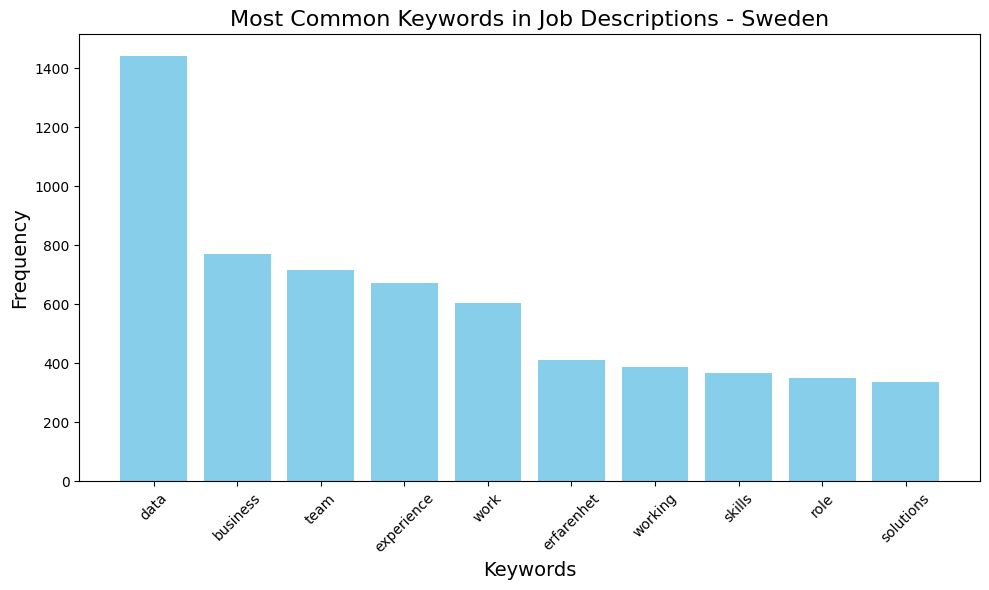

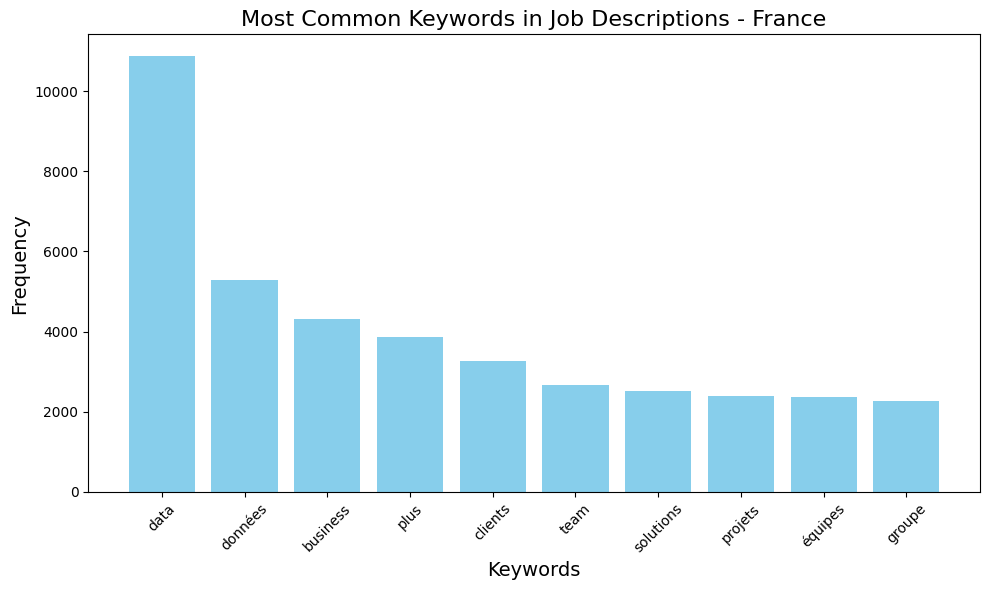

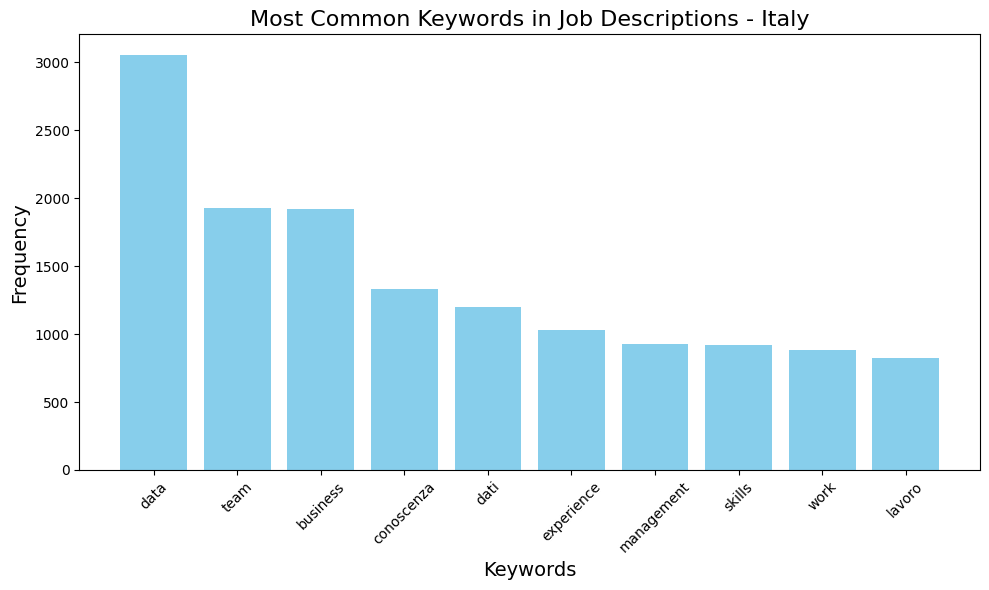

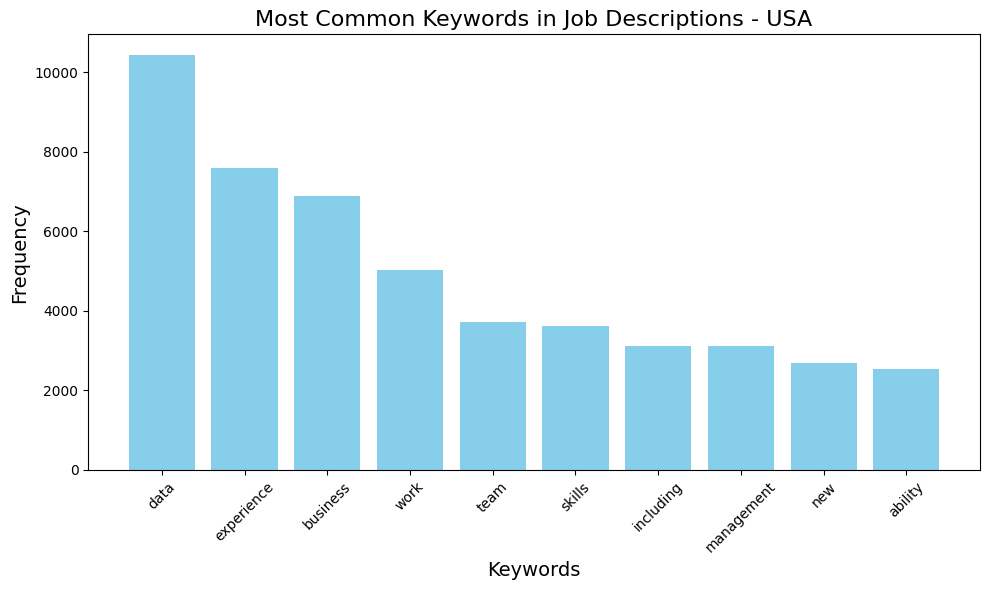

In [56]:
# Extract keywords 
common_keywords_SWE = tf.extract_keywords(result_df, 'Sweden', 'swedish')
common_keywords_FRA = tf.extract_keywords(result_df, 'France', 'french')
common_keywords_ITA = tf.extract_keywords(result_df, 'Italy', 'italian')
common_keywords_USA = tf.extract_keywords(result_df, 'USA', 'english')

# Plot common keywords 
pf.plot_common_keywords(common_keywords_SWE[0], 'Sweden')
pf.plot_common_keywords(common_keywords_FRA[0], 'France')
pf.plot_common_keywords(common_keywords_ITA[0], 'Italy')
pf.plot_common_keywords(common_keywords_USA[0], 'USA')

In [57]:
df_combined.head()

,page,country,job_link,search_keyword,search_location,job_title,company_name,company_location,salary,job_description,date,language
0,1,Sweden,https://se.indeed.com/rc/clk?jk=a54f123aa8f7ee...,Data Analyst,Stockholm,data analyst (data visualization),Swedium Global Services,Distansjobb in Stockholm,NaN,Data Analyst (Data Visualization) Swedium ...,2024-09-19,en
1,1,Sweden,https://se.indeed.com/rc/clk?jk=5dbbee34feadd8...,Data Analyst,Stockholm,data analyst,Deploja AB,169 73 Solna,NaN,Role: Website Performance: Web analyst foc...,2024-09-19,en
2,1,Sweden,https://se.indeed.com/rc/clk?jk=07cc3fa43334c5...,Data Analyst,Stockholm,data analyst,Cubane Solutions AB,Stockholm,Heltid,Responsibilities Website Performance: Web...,2024-09-19,en
3,1,Sweden,https://se.indeed.com/rc/clk?jk=265b21402a8391...,Data Analyst,Stockholm,data analyst,Sobi,Stockholm,Heltid,Company Description Statistics show that wo...,2024-09-19,en
4,1,Sweden,https://se.indeed.com/rc/clk?jk=65bfa8c313624f...,Data Analyst,Stockholm,"juniora analysts till operations, engineering,...",Deloitte,113 57 Stockholm,Heltid,Företagsbeskrivning Deloitte är en glob...,2024-09-19,sv


In [58]:

# Calculate software/programming keyword counts for each country 
keyword_counts_SWE = tf.count_keywords(result_df, 'Sweden', dicts.software_keywords)
keyword_counts_FRA = tf.count_keywords(result_df, 'France', dicts.software_keywords)
keyword_counts_ITA = tf.count_keywords(result_df, 'Italy', dicts.software_keywords)
keyword_counts_USA = tf.count_keywords(result_df, 'USA', dicts.software_keywords)

# Combine all dfs into one
keyword_counts_combined = pd.concat([keyword_counts_SWE, keyword_counts_FRA, keyword_counts_ITA, keyword_counts_USA], ignore_index=True)
keyword_counts_combined.sort_values(by=['Count'], ascending=[False])

,Category,Keyword,Search Keyword,Country,Count
352,Development Tools,git,Data Analyst,France,862
767,Data Analysis and Manipulation,excel,Data Analyst,USA,765
354,Development Tools,git,Product Analyst,France,704
243,Data Analysis and Manipulation,excel,Data Analyst,France,602
245,Data Analysis and Manipulation,excel,Product Analyst,France,602
...,...,...,...,...,...
151,Programming Languages,stata,Data Scientist,Sweden,1
152,Programming Languages,swift,Data Scientist,Sweden,1
188,Big Data Technologies,hdfs,Data Analyst,France,1
906,Programming Languages,ruby,Data Analyst,USA,1


In [62]:
# Extract interview information
interview_info_df, interview_flags_df = tf.extract_interview_details(df_combined, dicts.interview_stages)

# Sum only Boolean columns in interview_flags_df to count occurrences of each interview stage
stage_counts = interview_flags_df.select_dtypes(include='bool').sum()
stage_counts

filtered_df = interview_info_df[interview_info_df['case_study_text'].notna()]
filtered_df.head()

,job_id,job_title,job_link,phone_screening_text,technical_screening_text,case_study_text,coding_assessment_text,behavioral_interview_text,on_site_interview_text,presentation_text
425,426,data analyst - internship (m/w/n),https://www.indeed.fr/rc/clk?jk=58be71e68edb16...,None,None,"fit interview, one case study to test analytic...",None,None,None,None
427,428,transversal business analyst - internship - pa...,https://www.indeed.fr/rc/clk?jk=6005a985b0c4c2...,None,None,ition team. \n Excel case study. \n Final inte...,None,None,None,None
1422,1423,strategy & operations intern,https://www.indeed.fr/rc/clk?jk=b734e01506d4df...,ion form on Lever \n Screening call with curre...,None,Mission-specific case study with our Head of S...,None,None,None,None
1425,1426,strategy & operations intern,https://www.indeed.fr/rc/clk?jk=b734e01506d4df...,ion form on Lever \n Screening call with curre...,None,Mission-specific case study with our Head of S...,None,None,None,None
1437,1438,data analyst - product strategy (m/f/x),https://www.indeed.fr/rc/clk?jk=fe2845dfc269a5...,None,None,you to carry out a case study and meet your li...,None,None,None,None


Information about the interview process seems to mostly be missing/left out from the job listnings. However, the most common category appears to be stages such as case studies, followed by phone screening, technical assessments, and coding assessments.

## Univariate analysis 


In [ ]:
# - Numerical feature distribution
# - Categorical feature distribution

In [ ]:
# Categorical variables
categorical_cols = ['country', 'job_title', 'company_name', 'company_location']

# filtered_df = df_combined[df_combined['search_keyword'] == 'Data Scientist'][['country', 'search_keyword', 'job_title', 'company_name', 'company_location']]
# filtered_df['job_title'].value_counts()
# Things to fix for all job_title entries: to lower, remove (H/F) and (F/H) and H/F and F/H 


In [ ]:
# Plotting frequency distribution
pf.plot_categorical(df_combined, ['country'], top_n=4, horizontal=False)

In [ ]:
# Example usage
pf.plot_categorical(df_combined, ['job_title', 'company_name', 'company_location'], top_n=25, horizontal=True)
# It seems like the counts are not checking for CAPTIONS ! Need to add to lower
# Need to also group titles that are basically the same, e.g. strip (F/H) and (H/F) from french jobs 
# Same goes for Chicago, IL and so on 

Locations might need to be reformatted to fit better into map view in Tableau. 

In [ ]:
# There seem to be some formatting errors for certain salaries
# For example, there is a 41 in the middle here
df_combined['salary_num'].dropna()

In [ ]:
# Set the display options to show all rows and columns
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)

df_combined[df_combined['country'] == 'USA']['salary_num'].dropna()

In [ ]:
### Continue here! 

#df_combined[df_combined['salary_num'].notna()]
# France 
mask_fr = df_combined['job_id'].isin([286, 323, 556, 678, 659, 673, 727, 744, 896, 768, 1094, 1142, 1288, 1317, 1350, 1456, 1469, 1477, 1478, 1481, 1483])
df_combined[mask_fr] # this doesnt work! 

# USA 
#mask_US = df_combined['job_id'].isin([2205,2207, 2220])
#df_combined[mask_US] # this actually works fine! 

In [ ]:
mask = (df_combined['country'] == 'France') & (df_combined['min_salary_month_EUR'].notna())

df_combined[mask]

In [ ]:
# Histograms for salaries
fig, axes = plt.subplots(1, len(df_combined['country'].unique()), figsize=(16, 6))

# Create a histogram for each country
for i, country in enumerate(df_combined['country'].unique()):
    country_data = df_combined[df_combined['country'] == country]
    sns.histplot(
        x='min_salary_month_EUR',
        data=country_data,
        bins=10,
        kde=True,
        alpha=0.5,
        ax=axes[i]
    )
    axes[i].set_title(country)
    axes[i].set_xlabel('EUR')
    axes[i].set_ylabel('Frequency')

# Add a suptitle for the entire figure
plt.suptitle('Min Salary Distribution')
plt.tight_layout()

# Show the plot
plt.show()

Observations regarding salaries: 
- **Sweden**: has only two data points. This makes sense cause in Swedish interview processes you usually do not discuss salaries until the very end of the rounds. Range:  
- **France**: peaks at ..... Has errors in it. Some really low values are months instead of salaries. Range: 
- **Italy**: peaks at 1500 EUR per month. Interesting strange second peak at 4000 EUR.  Range: very large?
- **USA**: significantly higher salaries overall, as to be expected. Tons of outliers? Need to look into mins and max values. Range: 

In [ ]:
# Plot the maximum salaries too 
# Histograms for salaries
fig, axes = plt.subplots(1, len(df_combined['country'].unique()), figsize=(16, 6))

# Create a histogram for each country
for i, country in enumerate(df_combined['country'].unique()):
    country_data = df_combined[df_combined['country'] == country]
    sns.histplot(
        x='max_salary_month_EUR',
        data=country_data,
        bins=10,
        kde=True,
        alpha=0.5,
        ax=axes[i]
    )
    axes[i].set_title(country)
    axes[i].set_xlabel('EUR')
    axes[i].set_ylabel('Frequency')

# Add a suptitle for the entire figure
plt.suptitle('Max Salary Distribution')
plt.tight_layout()

# Show the plot
plt.show()

Peaks might suggest there are differences for different job titles? Lets check this. 

In [ ]:
# Histograms for salaries by job title
fig, axes = plt.subplots(1, len(df_combined['search_keyword'].unique()), figsize=(16, 6))

# Create a histogram for each job title
for i, job_title in enumerate(df_combined['search_keyword'].unique()):
    job_title_data = df_combined[df_combined['search_keyword'] == job_title]
    sns.histplot(
        x='min_salary_month_EUR',
        data=job_title_data,
        bins=10,
        kde=True,
        alpha=0.5,
        ax=axes[i]
    )
    axes[i].set_title(job_title)
    axes[i].set_xlabel('EUR')
    axes[i].set_ylabel('Frequency')

# Add a suptitle for the entire figure
plt.suptitle('Min Salary Distribution by Job Title')
plt.tight_layout()

# Show the plot
plt.show()

It might be interesting to look into the job listings that are particularly well paid. What are their characteristics? 

In [ ]:
df_combined.describe() # Check that min and max values make sense 

min_index = df_combined['min_salary_month_EUR'].idxmin()
row_with_min = df_combined.loc[df_combined['min_salary_month_EUR'].idxmin()]
#row_with_min['salary']
# seems like extraction of salary is not checking for what says after the number 
# there is also a max value of 3 that is messed up for France 

In [ ]:
country_mask = (df_combined['country'] == 'USA')
country = df_combined[country_mask]
numerical_columns = ['min_salary_month_EUR', 'max_salary_month_EUR']  # Replace with your actual numerical columns
pf.plot_numerical(country, numerical_columns)


In [ ]:
# Dont forget the new table keyword_counts_combined 

## Bivariate analysis 

In [ ]:
## Bivariate and Multivariate Analysis
# - Pairwise correlations
# - Relationships between key variables

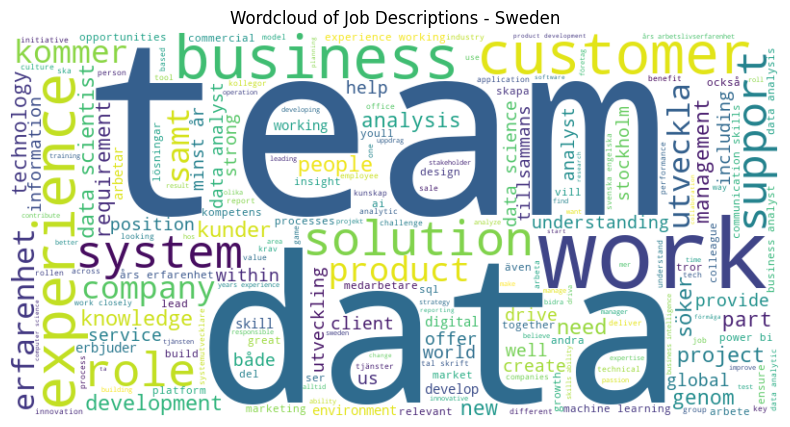

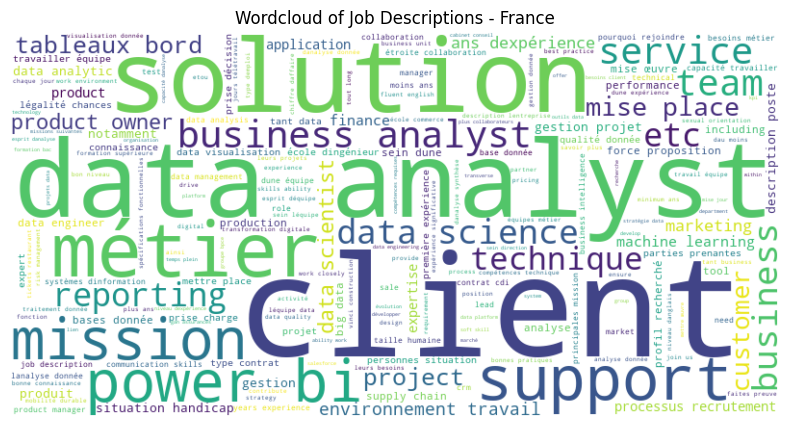

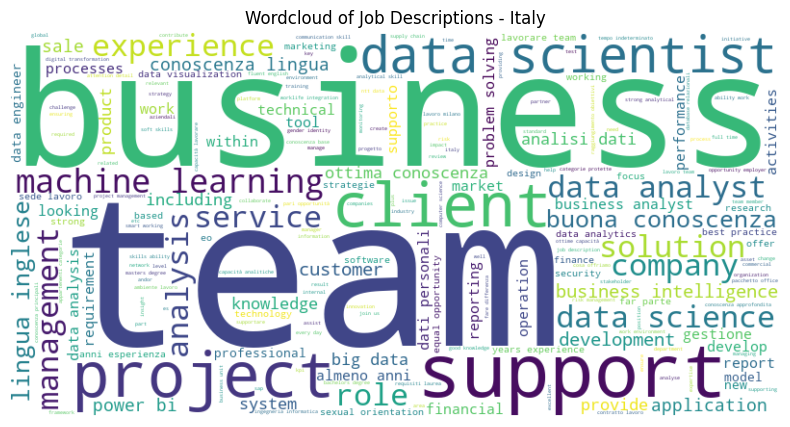

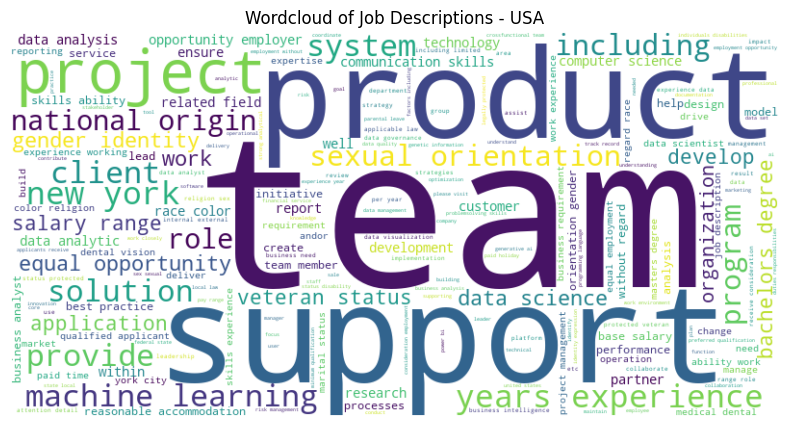

In [63]:
# Word cloud visualizations per country

pf.plot_wordtree(common_keywords_SWE[1], 'Sweden')
pf.plot_wordtree(common_keywords_FRA[1], 'France')
pf.plot_wordtree(common_keywords_ITA[1], 'Italy')
pf.plot_wordtree(common_keywords_USA[1], 'USA')

In [ ]:
# Add also word cloud visualizations per job title? 

In [64]:
# Number of job listings per job title and country 
# Box plots help visualize the distribution of salary ranges across different categories (e.g., job titles, countries).
# Look at outliers in the box plot! 

sns.boxplot(data=df_combined, x='search_keyword', y='min_salary_month_EUR')
plt.xticks(rotation=45)
plt.title('Salary Distribution by Job Title')
plt.show()

mean_salary = df_combined.groupby('search_keyword')['min_salary_month_EUR'].mean().reset_index()
sns.barplot(data=mean_salary, x='search_keyword', y='min_salary_month_EUR')
plt.xticks(rotation=45)
plt.title('Average Salary by Job Title')
plt.show()

sns.countplot(data=df_combined, x='search_keyword', hue='min_salary_month_EUR')
plt.xticks(rotation=45)
plt.title('Count of Job Titles by Salary Range')
plt.show()

sns.countplot(data=df_combined, x='search_keyword', hue='country')
plt.xticks(rotation=45)
plt.title('Count of Job Titles by Country')
plt.show()

ValueError: Could not interpret value `min_salary_month_EUR` for `y`. An entry with this name does not appear in `data`.

There are a bunch of data analyst (also data scientist) jobs that are very well paid. Do they have anything in common? 

In [ ]:
import scipy.stats as stats
salary_ranges = pd.cut(df_combined['salary_num_low'], bins=[0, 20000, 40000, 60000, 80000, 100000], labels=['<20k', '20-40k', '40-60k', '60-80k', '80-100k'])
crosstab = pd.crosstab(df_combined['search_keyword'], salary_ranges)
chi2, p, dof, expected = stats.chi2_contingency(crosstab)
print(f'Chi-squared: {chi2}, p-value: {p}')

In [ ]:
pivot_table = df_combined.pivot_table(values='max_salary_month_EUR', index='country', columns='search_keyword', aggfunc='mean')
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu')
plt.title('Average Salary Heatmap by Country and Job Title')
plt.show()

In [ ]:
# What if you remove USA? 
non_usa_mask = df_combined['country'] != 'USA'

# Create the pivot table using the non-USA rows
pivot_table_min = df_combined.loc[non_usa_mask].pivot_table(values='min_salary_month_EUR', index='country', columns='search_keyword', aggfunc='mean')
pivot_table_max = df_combined.loc[non_usa_mask].pivot_table(values='max_salary_month_EUR', index='country', columns='search_keyword', aggfunc='mean')

sns.heatmap(pivot_table_min, annot=True, cmap='YlGnBu')
plt.title('Average Min Salary Heatmap by Country and Job Title, if removing USA')
plt.show()

sns.heatmap(pivot_table_max, annot=True, cmap='YlGnBu')
plt.title('Average Max Salary Heatmap by Country and Job Title, if removing USA')
plt.show()

## Conclusions 
TBA.

Where did the analysis of programming languages etc. go?

Salaries: 
- As expected, salaries are significantly higher in the US. For some reason, maximum salaries appear to be for Data Analyst jobs? 
- If you want to be well paid in Europe, it seems like a good idea to become a Data Scientist in Sweden, or Product Analyst in France or Italy. There are tons of jobs that fell under the 'Product Analyst' title for France. Have to look into this. It would be worth looking into the job descriptions of these titles in France and Italy to understand this better. There are too few data points for Sweden. 

- Job titles appear to vary somewhat between countries (since top 3 ones were different for different countries). 
- Clean up job titles for different countries?
- Case studies 